## Understanding model performance by different demographics and geography

### Setup and import

In [60]:
import pandas as pd
import numpy as np
import yaml
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import geopandas as gpd


with open('database.yaml', 'r') as f:
    db_params = yaml.safe_load(f)

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(
  host=db_params['host'],
  port=db_params['port'],
  dbname=db_params['db'],
  user=db_params['user'],
  password=db_params['pass']    
))

In [20]:
# Import test results 
df = pd.read_csv('modeling_pipeline/matrices/y_test_ids.csv')
preds = np.genfromtxt('modeling_pipeline/test_preds.txt')
df['preds'] = preds

# Create error stats at parcel-level
df['error'] = df['preds'] - df['building_value'] 
df['abs_error'] = abs(df['error'])
df['abs_perc_error'] = 100*(df['abs_error'] / df['building_value'])
df['squared_perc_error'] = (df['error'] / df['building_value'])**2

# Import demographic data
demo = pd.read_sql('select * from census_demographics', engine)

# Merge with test set data
df = pd.merge(df, demo, on='parcelid', how='left')
print(f"{len(df[df['medianincome'].isna()])} test samples have missing demographic info")

# Rename some variables more intuitively
df.rename(columns={'total':'total_pop'}, inplace=True)

# Subset to 5th-95th percentile
perc_5 = 1140
perc_95 = 6715

df_sub = df[(df['building_value'] >= perc_5)&(df['building_value'] <= perc_95)]

# Print MAPE, check that this aligns with the paper
print(f"MAPE on 5-95 test subset: {df_sub['abs_perc_error'].mean()}")
print("This aligns with the numbers in the paper -- all good!")

5 test samples have missing demographic info
MAPE on 5-95 test subset: 17.481637331364908


In [21]:
df_sub

,parcelid,building_value,preds,error,abs_error,abs_perc_error,squared_perc_error,GEOID,countyfips,TRACTCE,...,total,whitepro,blackpro,indigenouspro,latinxpro,asianpro,raceotherpro,owneroccpro,vacantpro,singlefampro
2,1300006002300,2730.0,2352.647618,-377.352382,377.352382,13.822432,0.019106,39061005800,39061.0,005800,...,5020.0,0.287052,0.634861,0.004383,0.045020,0.003586,0.025100,0.434845,0.077034,0.488481
3,1300006002300,2730.0,2352.647618,-377.352382,377.352382,13.822432,0.019106,39061023800,39061.0,023800,...,5196.0,0.382217,0.435912,0.010585,0.056005,0.012317,0.102964,0.432478,0.099932,0.540176
4,0500005012100,4220.0,3982.391377,-237.608623,237.608623,5.630536,0.003170,39061005301,39061.0,005301,...,3854.0,0.820706,0.141411,0.000000,0.019979,0.017903,0.000000,0.325900,0.089623,0.386792
5,5920004005900,4010.0,4155.799044,145.799044,145.799044,3.635886,0.001322,39061022601,39061.0,022601,...,6363.0,0.837184,0.107339,0.000000,0.011001,0.025460,0.019016,0.935874,0.000000,0.912175
6,6510018001900,3150.0,2578.619128,-571.380872,571.380872,18.139075,0.032903,39061025300,39061.0,025300,...,2650.0,0.773585,0.148679,0.000000,0.068302,0.000000,0.009434,0.408907,0.145074,0.512821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,0570005007200,4850.0,4435.307250,-414.692750,414.692750,8.550366,0.007311,39061004000,39061.0,004000,...,2134.0,0.463449,0.460637,0.000000,0.020150,0.006560,0.049203,0.570878,0.142719,0.594021
2110,0580005007100,3680.0,3509.527389,-170.472611,170.472611,4.632408,0.002146,39061003800,39061.0,003800,...,1893.0,0.134707,0.857369,0.005283,0.000000,0.002641,0.000000,0.267277,0.203164,0.407993
2111,0360004018400,2540.0,2576.142425,36.142425,36.142425,1.422930,0.000202,39061005600,39061.0,005600,...,5967.0,0.695995,0.212502,0.000000,0.057148,0.011228,0.023127,0.648307,0.023818,0.845553
2112,5510002008900,3220.0,2529.635925,-690.364075,690.364075,21.439878,0.045967,39061020902,39061.0,020902,...,5311.0,0.768217,0.157974,0.000000,0.022030,0.007720,0.044060,0.336283,0.107670,0.438053


## Raw error plots against variables of interest

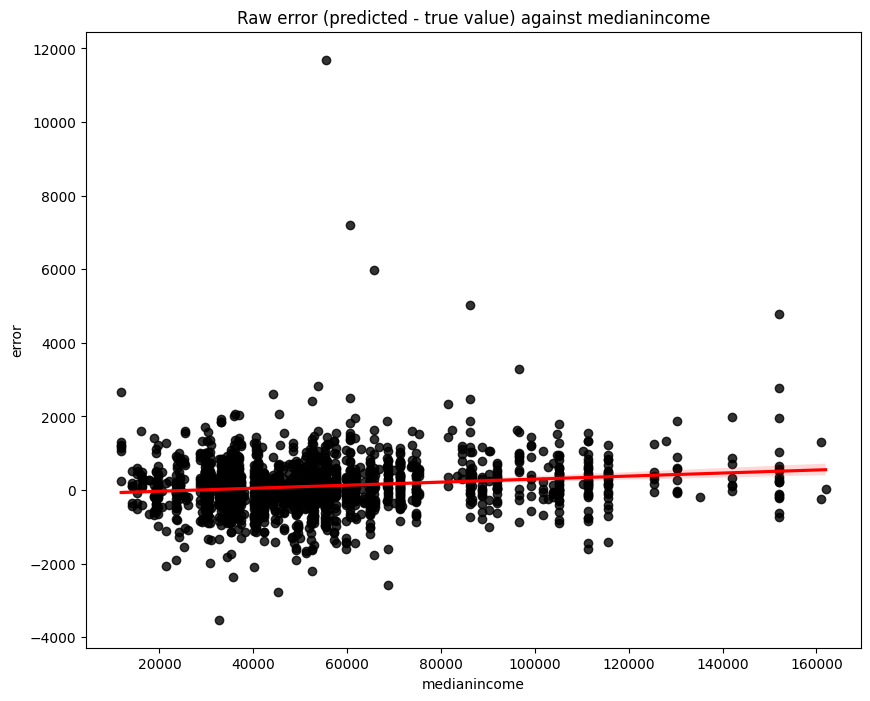

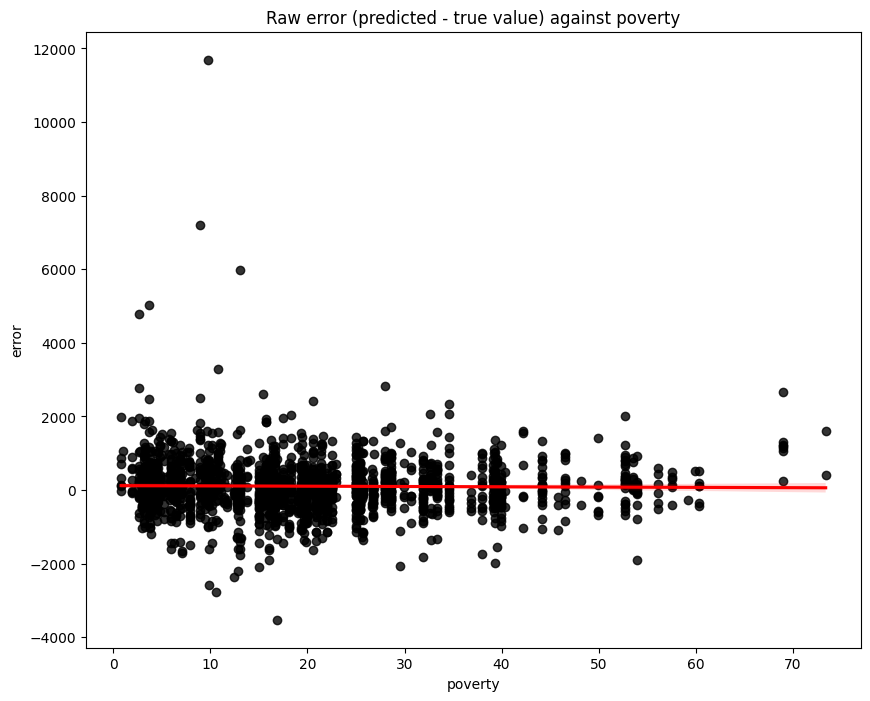

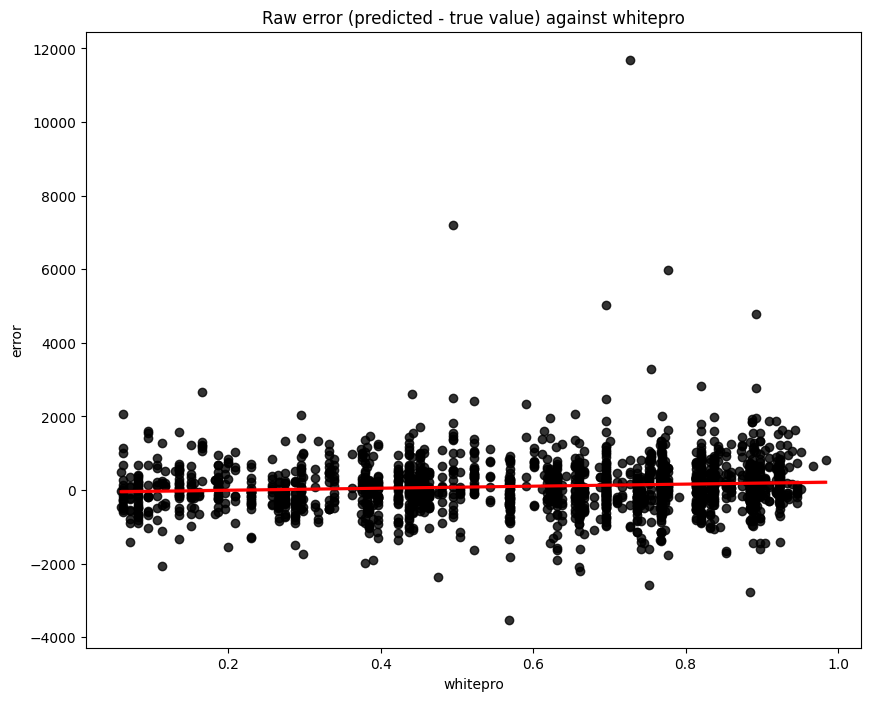

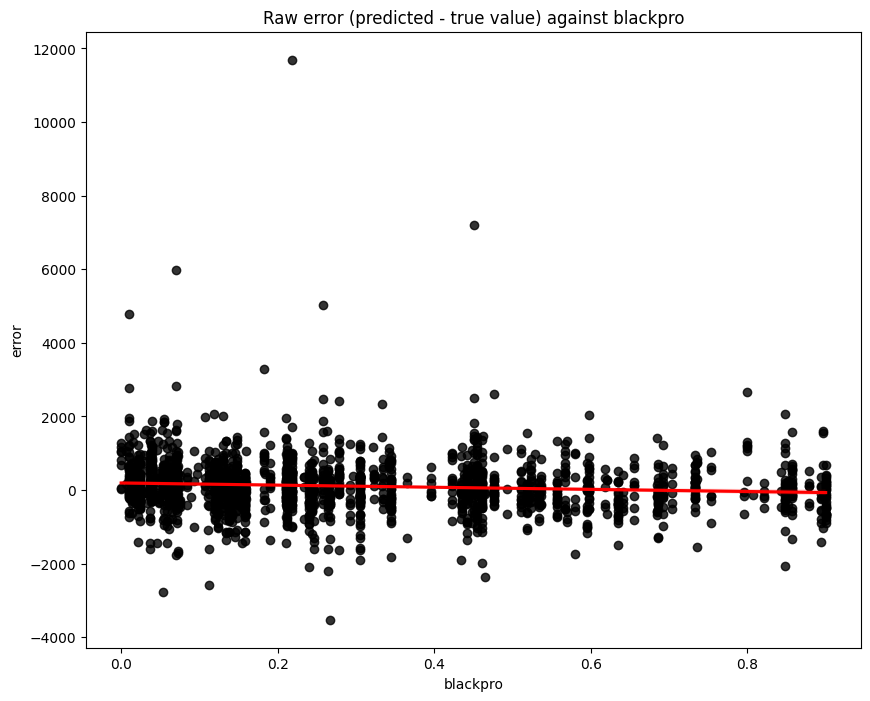

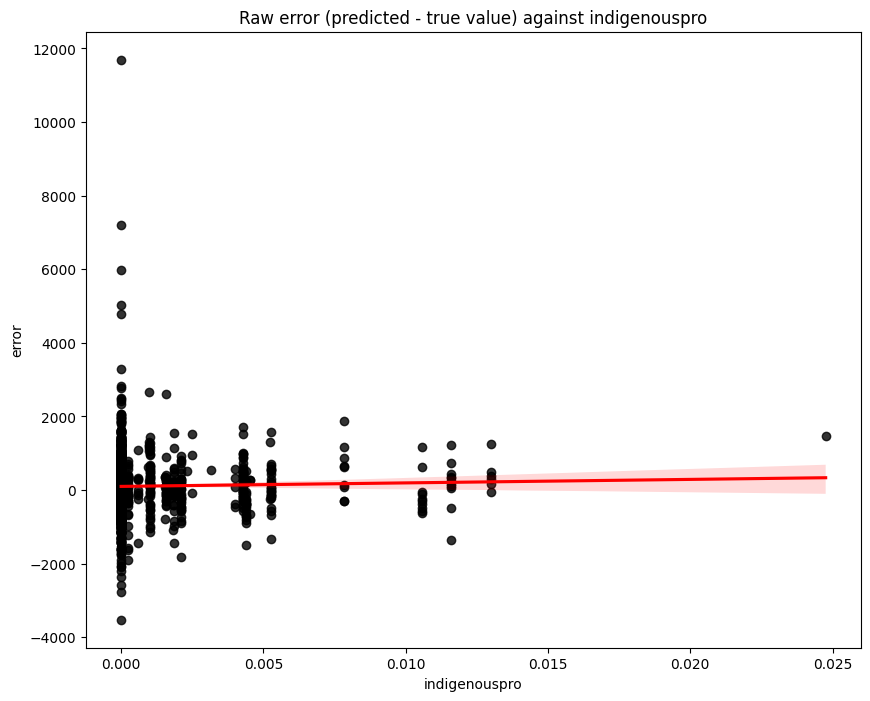

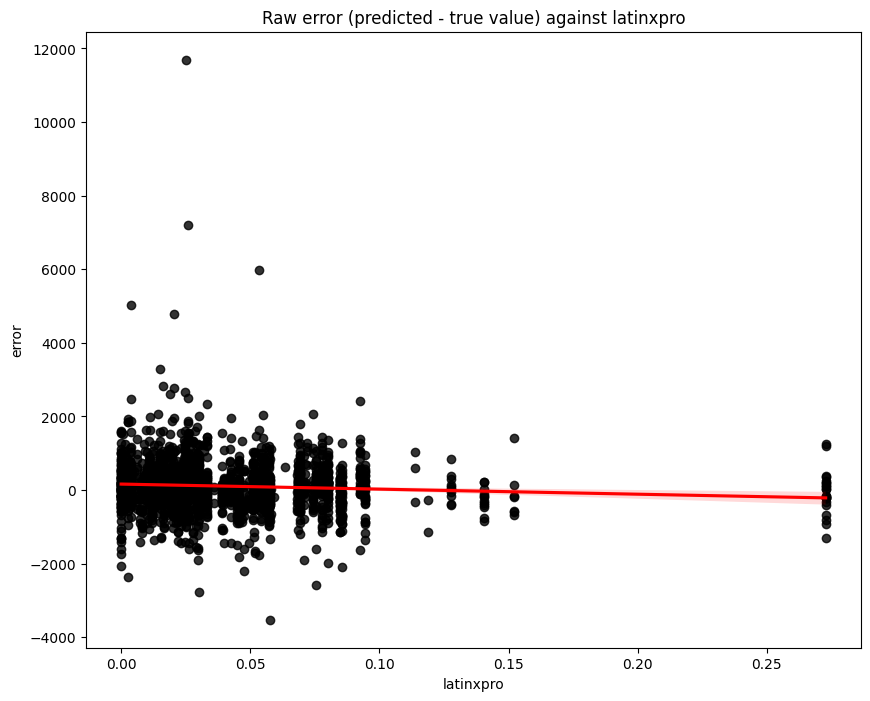

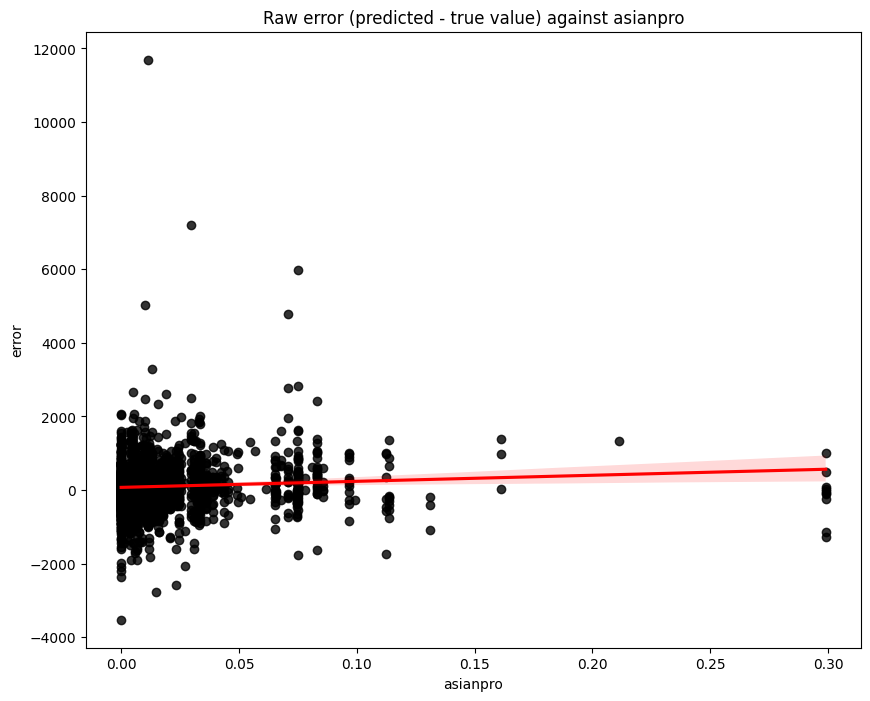

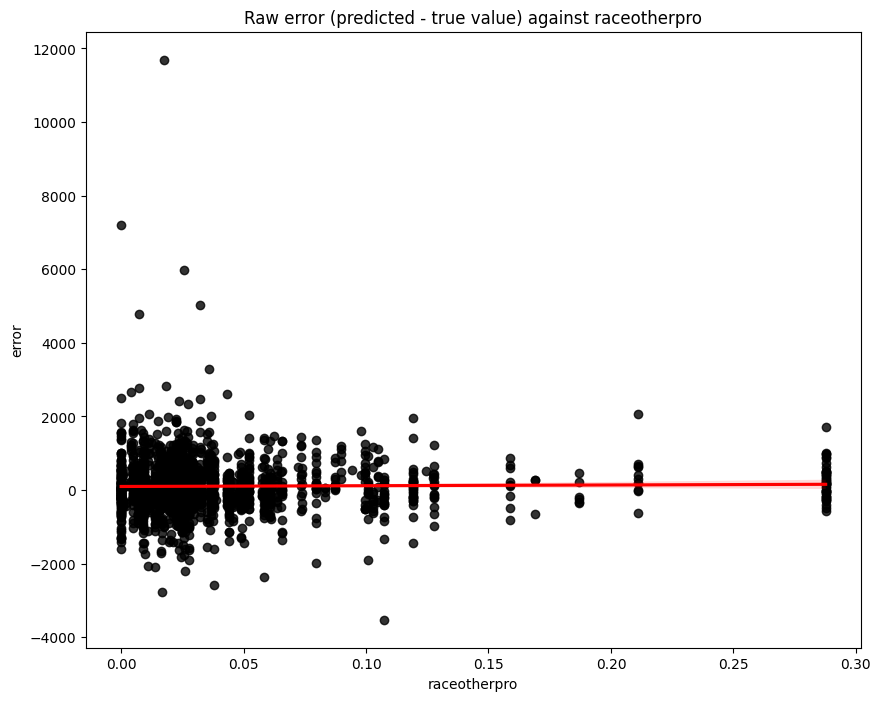

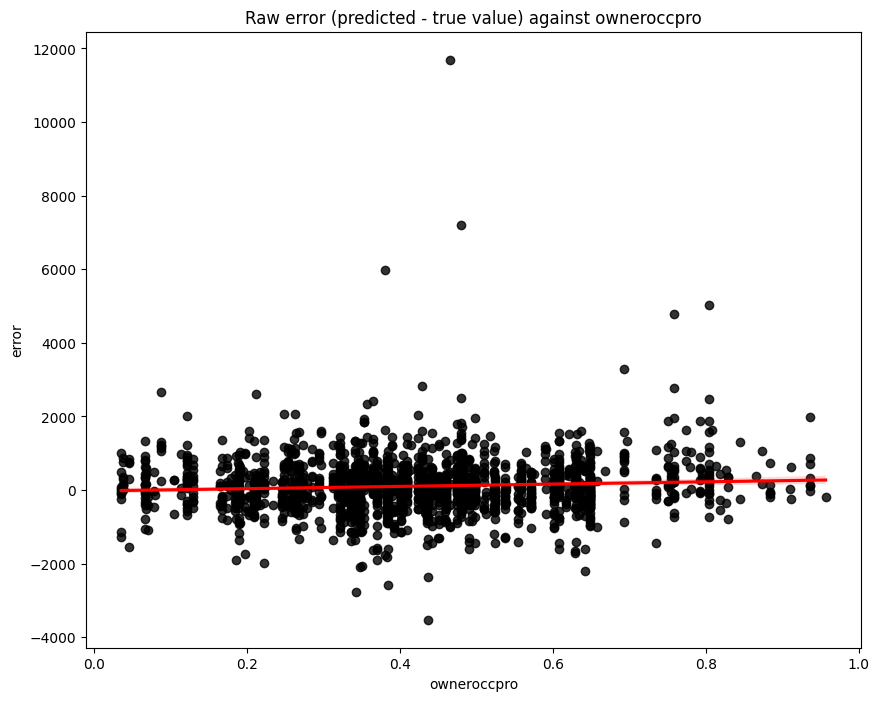

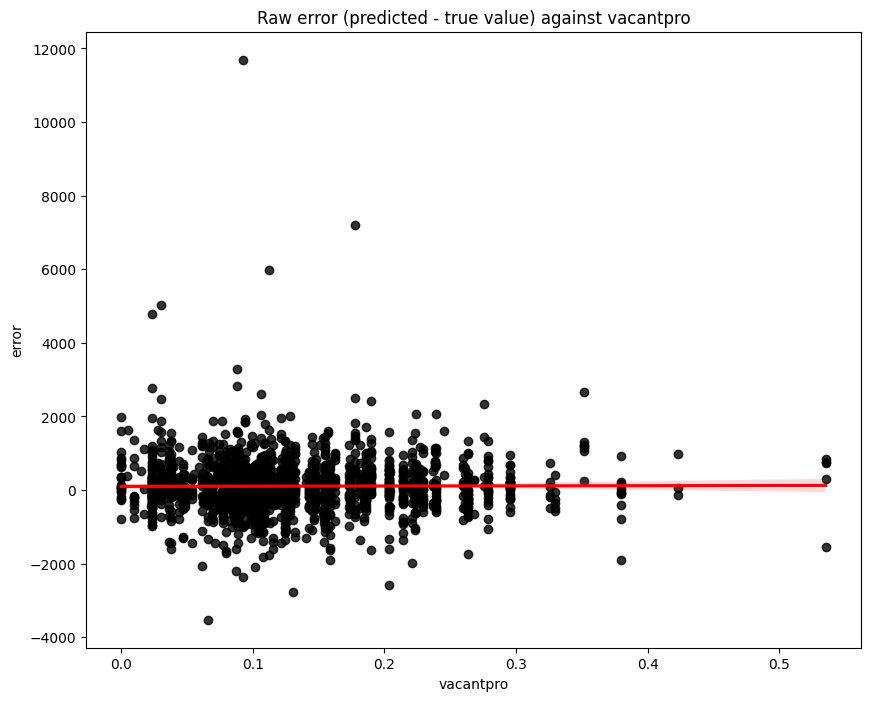

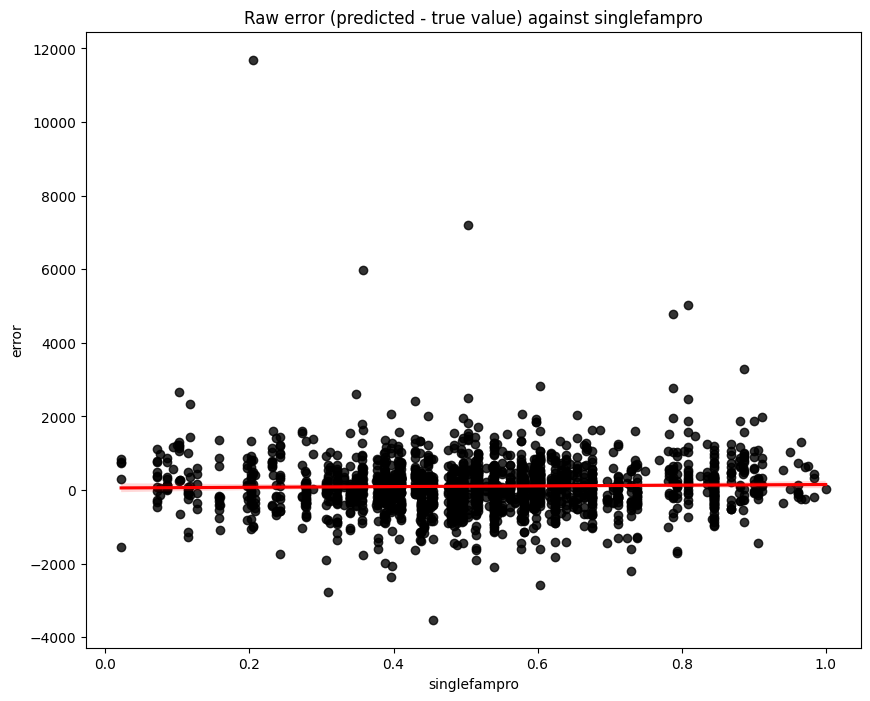

In [35]:
vars_of_interest = ['medianincome','total_pop','poverty','whitepro', 'blackpro', 'indigenouspro', 'latinxpro', 'asianpro', 'raceotherpro', 'owneroccpro', 'vacantpro', 'singlefampro']

for var in vars_of_interest:
    plt.figure(figsize=(10,8))
    sns.regplot(df_sub, x=var, y='error', scatter_kws={"color":"black"}, line_kws={"color":"red"})
    plt.title(f'Raw error (predicted - true value) against {var}')
    plt.show()

### Mean Absolute Percentage Error correlation with variables of interest

In [31]:
# Simple correlations of various demographic characteristics with abs_perc_error
df_sub[['medianincome','total_pop','poverty','whitepro', 'blackpro', 'indigenouspro', 'latinxpro', 'asianpro', 'raceotherpro', 'owneroccpro', 'vacantpro', 'singlefampro']].corrwith(df['abs_perc_error']).sort_values()

latinxpro       -0.068188
blackpro        -0.045401
raceotherpro    -0.004754
vacantpro        0.006366
poverty          0.023165
asianpro         0.026173
indigenouspro    0.045151
singlefampro     0.051863
whitepro         0.052585
owneroccpro      0.052952
medianincome     0.069869
dtype: float64

### Visualizing errors in space

In [50]:
# Census tracts (shared by Junia)
tracts = gpd.read_file(r"C:\Users\mihir\Downloads\tl_2020_39_tract (1)\tl_2020_39_tract.shp")

# Restrict tracts data to just hamilton county for faster processing 
tracts['countyfips'] = tracts['STATEFP'] + tracts['COUNTYFP']
tracts_hamilton = tracts[tracts['countyfips'] == '39061']

# Correcting CRS
tracts_hamilton['geometry'] = tracts_hamilton['geometry'].to_crs(epsg=3857)

# Creating tract-level dataset from errors df
tractlevel_errors = df_sub.groupby('TRACTCE').mean().reset_index()
tractcounts = df_sub.groupby('TRACTCE')['parcelid'].count().reset_index()
tractlevel_errors = pd.merge(tractlevel_errors, tractcounts, on='TRACTCE')

# Merging onto geographic data
tracts_hamilton = pd.merge(tracts_hamilton, tractlevel_errors, on='TRACTCE')

print(f"There are {len(tracts_hamilton)} tracts represented in the test set")

160


c:\Users\mihir\gitclones\ErukaExp\eruka\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\mihir\AppData\Local\Temp\ipykernel_18276\1967408039.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tractlevel_errors = df_sub.groupby('TRACTCE').mean().reset_index()


#### How are average building values (our target var) distributed across tracts?

Text(0.5, 1.0, 'Average building value (target var) by tract\nNumbers indicate the count of test samples in that tract')

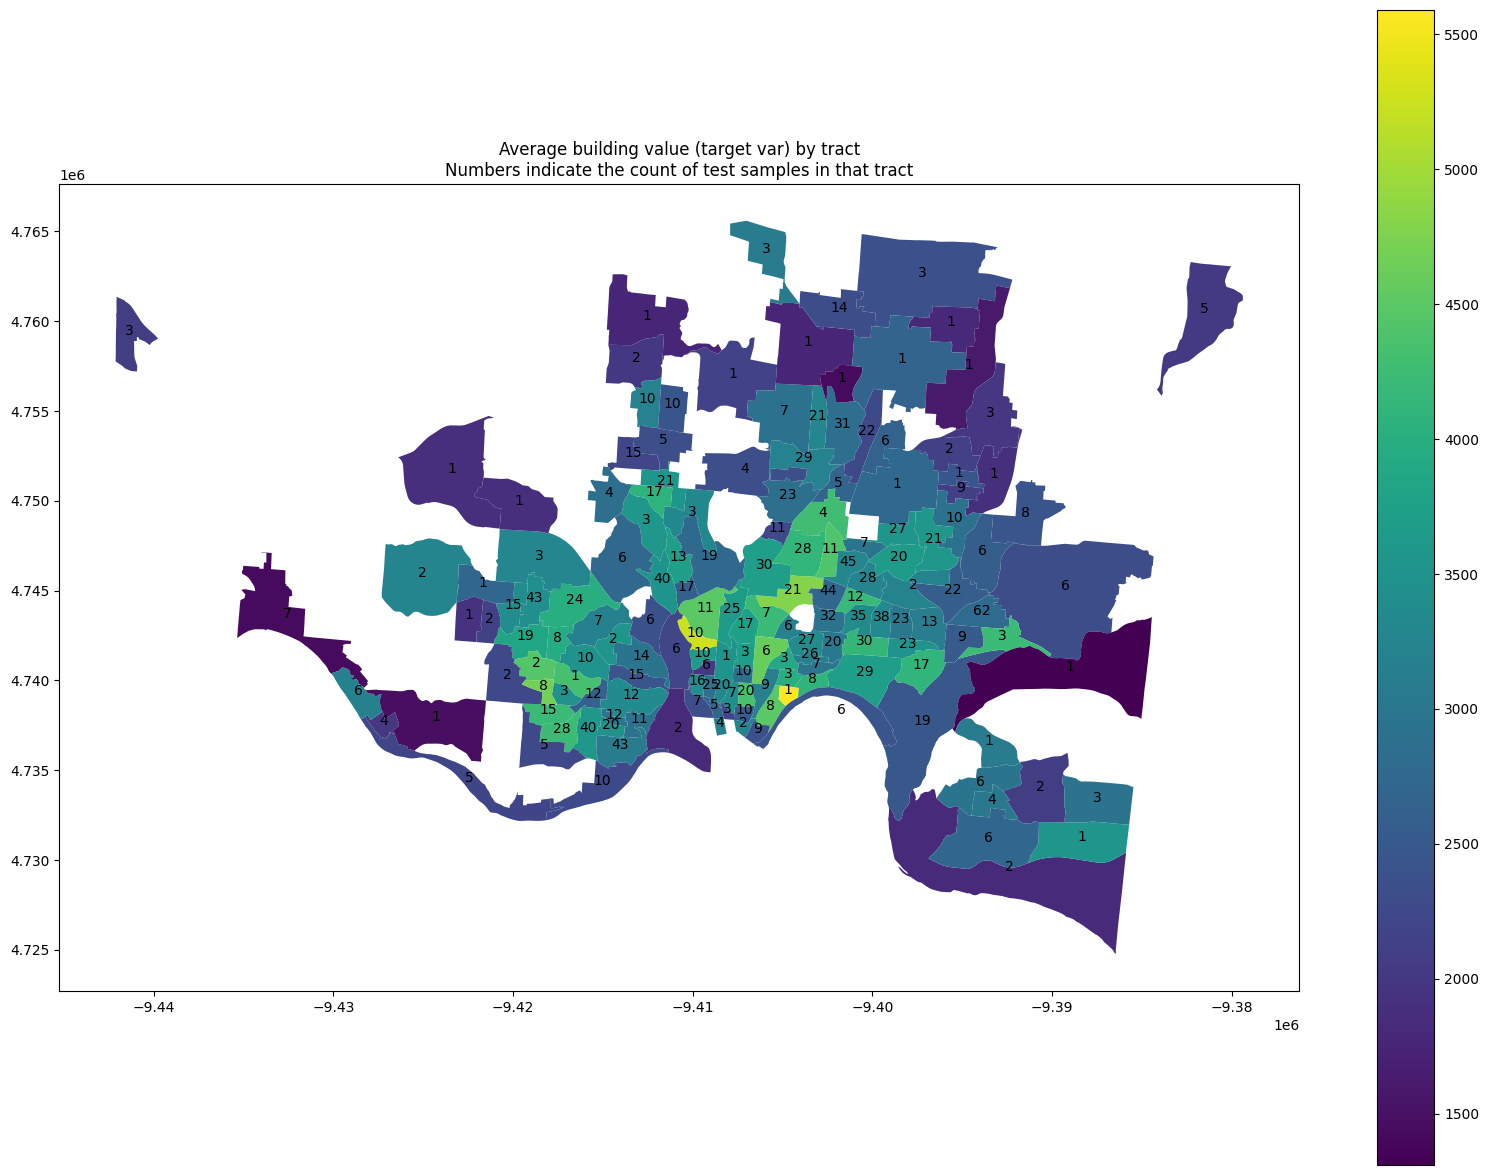

In [57]:
# First, a plot of what Hamilton looks like: how are tracts based on average building value? 
plt.rcParams["figure.figsize"]=20,15
tracts_hamilton.plot(column='building_value', legend=True)
tracts_hamilton.apply(lambda x: plt.annotate(text=x['parcelid'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.title('Average building value (target var) by tract\nNumbers indicate the count of test samples in that tract')

#### How are is mean absolute percentage error (MAPE) distributed across tracts?

Text(0.5, 1.0, 'Average MAPE by tract\nNumbers indicate the count of test samples in that tract')

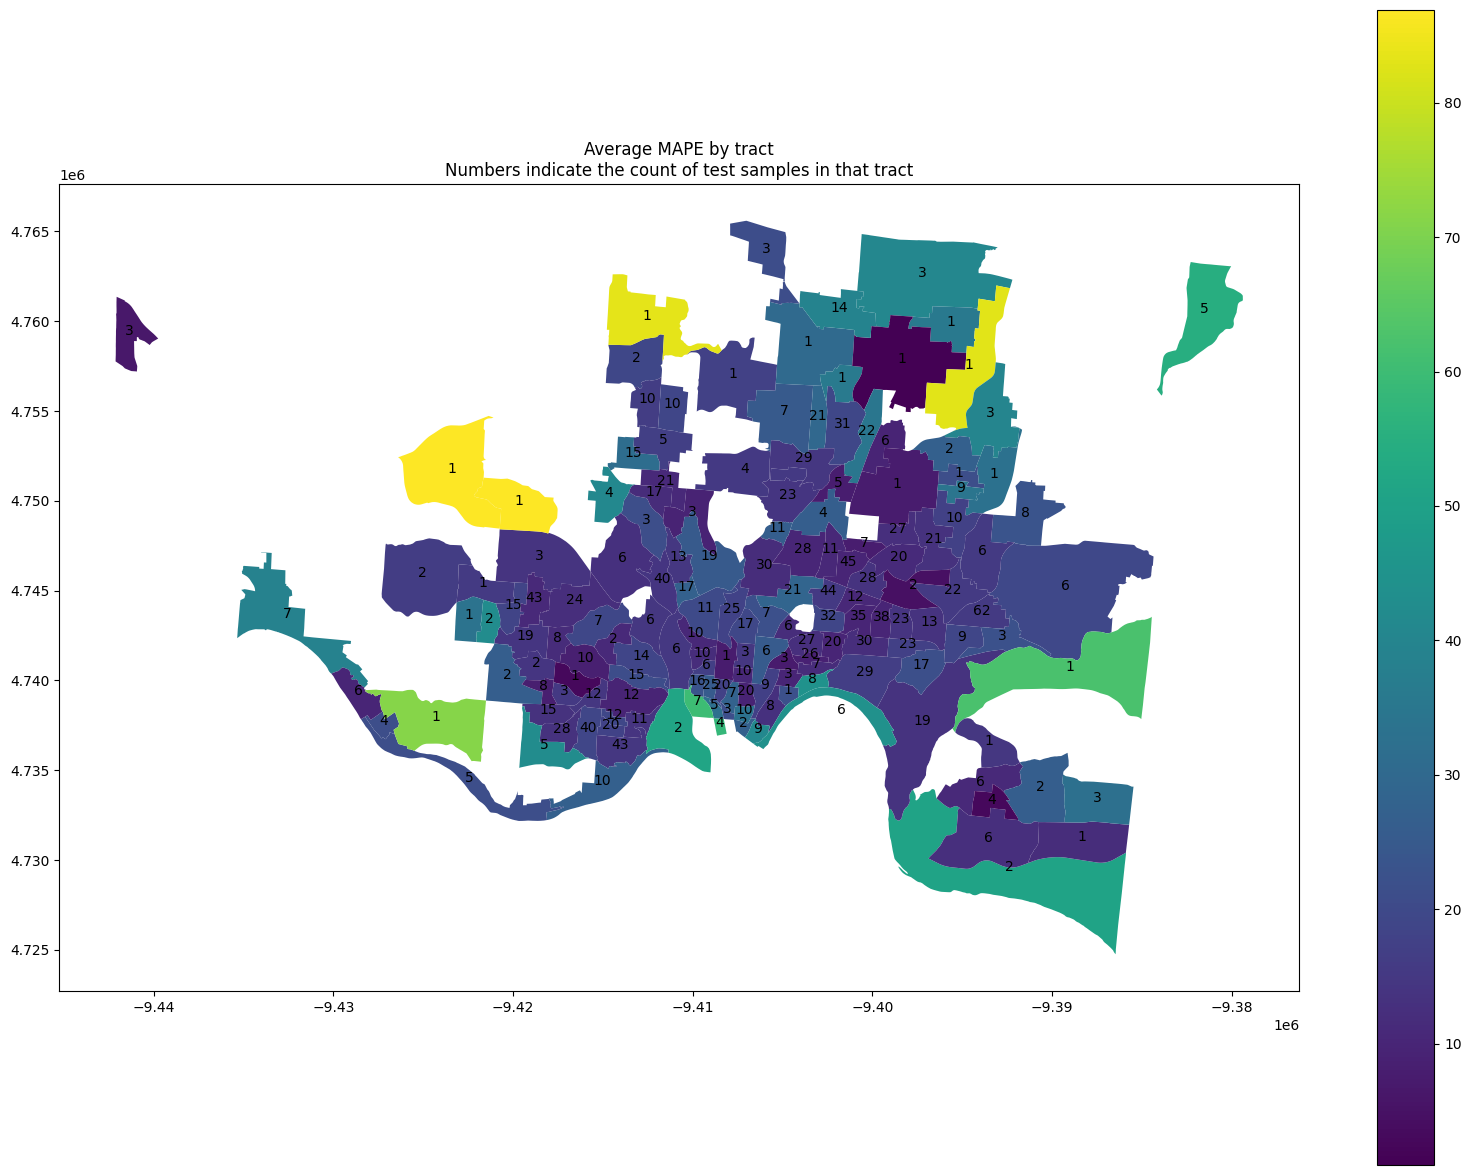

In [56]:
plt.rcParams["figure.figsize"]=20,15
tracts_hamilton.plot(column='abs_perc_error', legend=True)
tracts_hamilton.apply(lambda x: plt.annotate(text=x['parcelid'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.title('Average MAPE by tract\nNumbers indicate the count of test samples in that tract')


In [58]:
# Export file for uploading to Felt, online mapping tool
tracts_hamilton.to_file('hamilton_tracts')

C:\Users\mihir\AppData\Local\Temp\ipykernel_18276\2195924658.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tracts_hamilton.to_file('hamilton_tracts')


In [ ]:
# # Importing geographic data (parcel footprints and tract footprints)
# parcel_footprints = gpd.read_file(r"C:\Users\mihir\Downloads\Hamilton_County_Parcels\Parcel_Merged_Consolidations.shp")

# # Creating correct parcelid for merge
# parcel_footprints['MLTOWN'] = parcel_footprints['MLTOWN'].fillna(0)


# parcel_footprints['parcelid'] = parcel_footprints.apply(lambda row: str(row['BOOK']).zfill(3) +
#                                                       str(row['PAGE']).zfill(4) +
#                                                       str(row['PARCEL']).zfill(4) +
#                                                       str(int(row['MLTOWN'])).zfill(2), axis=1)


# # Merging datasets
# parcel_footprints = pd.merge(parcel_footprints, df_sub, on='parcelid', how='inner')

